<a href="https://colab.research.google.com/github/jjung2-oxy/Natural-Lang-Processing/blob/main/NLP_Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# GET DATA FROM GOOGLE DRIVE

# Get Negative Reviews
neg_directory = r'/content/drive/MyDrive/Homework2-Data/neg'
neg_sentiment = []

for file in os.listdir(neg_directory):
    f = os.path.join(neg_directory, file)
    
    if os.path.isfile(f) and file.endswith('.txt'):
      with open(f, encoding='utf-8') as text:
          contents = text.read()
          neg_sentiment.append(contents)


# Get Positive Reviews
pos_directory = r'/content/drive/MyDrive/Homework2-Data/pos'
pos_sentiment = []
for file in os.listdir(pos_directory):
    f = os.path.join(pos_directory, file)
    
    if os.path.isfile(f) and file.endswith('.txt'):
      with open(f, encoding='utf-8') as text:
          contents = text.read()
          pos_sentiment.append(contents)

# Get Affin Polarity Dictionary
affin_pos = set()
affin_neg = set()
for line in open("/content/drive/MyDrive/Homework2-Data/AFINN-96.txt"):
    x = line.split('\t')

    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stemmed = [porter.stem(x[0])]

    polarity = int(x[1].rstrip("\n"))

# Save words with polarity +2 as positive, and words with polarity -2 as negative. Leave out neutral words.
    if polarity >= 2:
        affin_pos.add(stemmed[0])
    elif polarity <= -2:
        affin_neg.add(stemmed[0])

{'endors', 'sweet', 'grand', 'favorit', 'cleaner', 'solid', 'congratul', 'amus', 'reward', 'fulfil', 'prosper', 'humor', 'ok', 'tender', 'nifti', 'live', 'exclus', 'cheer', 'use', 'celebr', 'pleasant', 'perfect', 'better', 'enjoy', 'greater', 'brave', 'intact', 'landmark', 'scoop', 'congrat', 'swift', 'wowow', 'justifi', 'smile', 'clarifi', 'highlight', 'wealth', 'clean', 'back', 'fearless', 'woo', 'solidar', 'strengthen', 'stun', 'win', 'woohoo', 'attract', 'delight', 'greatest', 'strong', 'strongest', 'breathtak', 'true', 'kudo', 'fun', 'desir', 'sympathet', 'justic', 'asset', 'superb', 'commend', 'grate', 'honor', 'posit', 'willing', 'eager', 'ftw', 'remark', 'right direct', 'fantast', 'favor', 'rescu', 'creativ', 'swiftli', 'nice', 'wonder', 'thought', 'gloriou', 'inspir', 'respons', 'terrif', 'yeee', 'ambiti', 'bargain', 'dear', 'glad', 'sunshin', 'sparkl', 'care', 'popular', 'omin', 'support', 'peac', 'hilari', 'confid', 'growth', 'novel', 'wooo', 'humour', 'appreci', 'interest',

In [ ]:
# IMPORT RATINGS 

# Import Ratings for Unlabeled Data (can be used for other ratings...)
newLine = '\n'
f = '/content/drive/MyDrive/Homework2-Data/ratings/unlabeled.txt'
ratings = []

with open(f, encoding='utf-8') as text:
      contents = text.readlines()
      for x in contents:
        num1 = int(re.search(r'\d+', x).group())
        if num1 < 10:
            x = x.replace(x[:2], '')
        elif num1 < 100:
            x = x.replace(x[:3], '')
        elif num1 < 1000:
            x = x.replace(x[:4], '')
        elif num1 < 1001:
            x = x.replace(x[:5], '')
        num2 = int(re.search(r'\d+', x).group())
        ratings.append([num1,num2])

print(f"Ratings Length: {len(ratings)}")

Ratings Length: 1000


In [ ]:
# DATA PRE-PROCESSESING FOR NAIVE BAYES

import nltk
import re
nltk.download("punkt")
nltk.download("stopwords")
!apt install -qq enchant
!pip install pyenchant

# Naive Bayes Preprocessing (For labeled data, not for unlabeled)
def nb_preprocess(pos_sentiment, neg_sentiment):
    '''
    Input:
          - Positive sentiment reviews
          - Negative sentiment reviews
          - Unlabeled sentiment reviews
    Output:
          - labeled reviews [labeled_reviews]
          - Processed features [data]
    '''

    print("Pre-Processing Data for Naive Bayes.")

    labeled_reviews = []

    print("\nProcessing positive sentiment reviews...")
    # Process positive sentiment reviews
    for doc in pos_sentiment:

        # Case folding
        doc = doc.lower();
        
        # Remove punctuation
        import string
        doc = "".join([char for char in doc if char not in string.punctuation])
        
        # Tokenization
        from nltk import word_tokenize
        tokens = word_tokenize(doc)

        # Remove stopwords
        from nltk.corpus import stopwords
        stopwords = stopwords.words("english")
        removed = [word for word in tokens if word not in stopwords]

        # Remove numbers
        words = [word for word in removed if word.isalpha()]

        # Remove non-english words
        import enchant
        d = enchant.Dict("en_US")
        for word in words:
            if not d.check(word):
                words.remove(word)
        # Stemming
        from nltk.stem.porter import PorterStemmer
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in words]

        # Append processed features to labeled_reviews
        processed_words = stemmed
        labeled_reviews.append((processed_words, "pos"))

    # Process negative sentiment reviews
    print("Processing negative sentiment reviews...")
    for doc in neg_sentiment:

        # Case folding
        doc = doc.lower();
        
        # Remove punctuation
        import string
        doc = "".join([char for char in doc if char not in string.punctuation])
        
        # Tokenization
        from nltk import word_tokenize
        tokens = word_tokenize(doc)

        # Remove stopwords
        from nltk.corpus import stopwords
        stopwords = stopwords.words("english")
        removed = [word for word in tokens if word not in stopwords]

        # Remove numbers
        words = [word for word in removed if word.isalpha()]

        # Remove non-english words
        import enchant
        d = enchant.Dict("en_US")
        for word in words:
            if not d.check(word):
                words.remove(word)

        # Stemming
        from nltk.stem.porter import PorterStemmer
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in words]

        # Append processed features to labeled_reviews
        processed_words = stemmed
        labeled_reviews.append((processed_words, "neg"))

    print("Labeled Reviews Length:", len(labeled_reviews))

    # Creation of bag of words set
    print("\nCreating bag of words...")
    bag_of_words = set()
    for words, label in labeled_reviews:
        for word in words:
            bag_of_words.add(word)
    print("Bag Of Words Length:", len(bag_of_words))

    # Creation of word table [(word in review: (bool if word exists in bag of words), class]
    print("\nCreating Data word table...")
    data = []

    for count in labeled_reviews:
      review = {}
      temp = count[0]
      for word in bag_of_words:
        bl = False
        if word in temp:
          bl = True
        review[word] = bl
      data.append((review, count[1]))


    print("Data Length:", len(data))

    return labeled_reviews, data, bag_of_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,312 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Preconfiguring packages ...
Selecting previously unselected package libtext-iconv-perl.
(Reading database ...

In [ ]:
# POS AND NEGATIVE MOST COMMON WORDS

# For Data Exploration (not involved in True/Fake Review process)
def most_common_unigrams(labeled_reviews):
    print("\nFinding most common unigrams...")
    positive_words = []
    negative_words = []
    for review, label in labeled_reviews:
        if label == "pos":
            for word in review:
                positive_words.append(word)
        else:
            for word in review:
                negative_words.append(word)

    positive_fd = nltk.FreqDist(positive_words)
    negative_fd = nltk.FreqDist(negative_words)

    # Create common set of words in both positive and negative
    common_set = set(positive_fd).intersection(negative_fd)

    # Remove words in both positive and negative reviews
    for word in common_set:
        del positive_fd[word]
        del negative_fd[word]

    top_100_positive = {word for word, count in positive_fd.most_common(100)}
    top_100_negative = {word for word, count in negative_fd.most_common(100)}

    print("\nMost common positive unigrams:")
    print(positive_fd.most_common(50))
    print("\nMost common negative unigrams:")
    print(negative_fd.most_common(50))

    # Returns top 100 most frequent positive words and top 100 most frequent negative words
    return top_100_positive, top_100_negative

In [ ]:
# TRAIN NB CLASIFIER/ TEST NB CLASSIFIER
import random
import numpy as np
import collections
import nltk.metrics
from nltk.metrics.scores import (precision, recall)

def show_most_informative_features_in_list(classifier, n=40):
    """
    Return a nested list of the "most informative" features
    used by the classifier along with it's predominant labels
    """
    cpdist = classifier._feature_probdist       # probability distribution for feature values given labels
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()],
                        key=labelprob)
        feature_list.append([fname, labels[-1]])
    return feature_list

# Takes feature list from show_most_informative_features_in_list and returns positive informative words and negative informative words
def informative_feature_list(classifier, n):
    most_info_list = show_most_informative_features_in_list(classifier, n)

    pos_nltk_words = []
    neg_nltk_words = []

    for x in most_info_list:
        if x[1] == "pos" and len(pos_nltk_words) <= 50:
            pos_nltk_words.append(x[0])

        if x[1] == "neg" and len(neg_nltk_words) <= 50:
            neg_nltk_words.append(x[0])

    return pos_nltk_words, neg_nltk_words

# Trains and Tests Naive Bayes Classifier (For Data Exploration, not involved in True/Fake Review Process)
def train_test_nb(data, num_folds=5):

    print("Training Naive Bayes Classifier...")
    pos_precision = 0
    neg_precision = 0
    pos_recall = 0
    neg_recall = 0
    accuracy = 0

    positive_set = set()
    negative_set = set()

    # Randomize order of data
    print("\nData shuffling...")
    random.shuffle(data)

    # K-Fold Cross-Validation
    print(f"\nRunning {num_folds}-fold cross validation...")
    subset_size = (int)(len(data)/num_folds)
    for i in range(num_folds):
        pos_words = []
        neg_words = []
        # Split into 1 testing and 9 training folds
        testing_this_round = data[i*subset_size:][:subset_size]
        training_this_round = data[:i*subset_size] + data[(i+1)*subset_size:]

        # train classifier using training_this_round
        print("\nTraining classifier on train folds...")
        nb_classifier = nltk.NaiveBayesClassifier.train(training_this_round)
        pos_words, neg_words = informative_feature_list(nb_classifier, n=60)

        for word in pos_words:
            positive_set.add(word)
        for word in neg_words:
            negative_set.add(word)

        # evaluate classifier against testing_this_round
        truesets = collections.defaultdict(set)
        classifiersets = collections.defaultdict(set)

        print("\nTesting classifier on test fold...")
        for i, (doc, label) in enumerate(testing_this_round):

            # Save doc # to true label category
            truesets[label].add(i)

            # Classify document using NaiveBayes
            observed = nb_classifier.classify(doc)
            nb_classifier.show_most_informative_features()

            # Save doc # to classified label category
            classifiersets[observed].add(i)

        # save precision
        pos_precision = pos_precision + precision(truesets['pos'], classifiersets['pos'])
        neg_precision = neg_precision + precision(truesets['neg'], classifiersets['neg'])


        # Save recall
        pos_recall = pos_recall + recall(truesets['pos'], classifiersets['pos'])
        neg_recall = neg_recall + recall(truesets['neg'], classifiersets['neg'])

        # Save accuracy
        accuracy = accuracy + nltk.classify.accuracy(nb_classifier, testing_this_round)
        


    # find avg precision over all rounds and f-score
    pos_precision_avg = pos_precision / num_folds
    neg_precision_avg = neg_precision / num_folds
    pos_recall_avg = pos_recall / num_folds
    neg_recall_avg = neg_recall / num_folds
    accuracy_avg = accuracy / num_folds
    pos_f_score = (2 * pos_precision_avg * pos_recall_avg) / (pos_precision_avg + pos_recall_avg)
    neg_f_score = (2 * neg_precision_avg * neg_recall_avg) / (neg_precision_avg + neg_recall_avg)

    print(f"\nPos Precision Average: {pos_precision_avg * 100}%")
    print(f"Pos Recall Average: {pos_recall_avg * 100}%")
    print(f"Pos F-Score {pos_f_score * 100}%")

    print(f"\nNeg Precision Average: {neg_precision_avg * 100}%")
    print(f"Neg Recall Average: {neg_recall_avg * 100}%")
    print(f"Neg F-Score: {neg_f_score* 100} %")

    print(f"\nAccuracy Average: {accuracy_avg * 100}%")


    textfile = "/content/drive/MyDrive/Homework2-Data/pos_unigrams.txt"
    with open(textfile, 'wb') as fp:
        pickle.dump(positive_set, fp)

    textfile = "/content/drive/MyDrive/Homework2-Data/neg_unigrams.txt"
    with open(textfile, 'wb') as fp:
        pickle.dump(negative_set, fp)

    # Returns most informative feature pos/neg words and Naive Bayes classifier for general use
    return positive_set, negative_set, nb_classifier


In [ ]:
# LOGREG Pre-Process
from nltk.util import trigrams
from nltk.util import bigrams

# Takes labeled reviews and creates bigram version and trigram version
def bigram_trigram_creator(labeled_reviews):

    print("\nCreating bigrams/trigrams from labeled reviews...")
    bigram_labeled_reviews = []
    trigram_labeled_reviews = []
    for review, label in labeled_reviews:
        gram = list(bigrams(review))
        bigram_labeled_reviews.append((gram, label))

        gram = list(trigrams(review))
        trigram_labeled_reviews.append((gram, label))
    
    return bigram_labeled_reviews, trigram_labeled_reviews

# Takes labeled bigrams and trigrams and finds most commonly occuring bigrams and trigrams based on label. (var = amount of most common words wanted)
def ngram_most_common(labeled_bigrams, labeled_trigrams, var=100):

    positive_bigrams = []
    negative_bigrams = []
    positive_trigrams = []
    negative_trigrams = []

    print("\nFinding most common bigrams/trigrams...")
    for review, label in labeled_bigrams:
        if label == "pos":
            for word in review:
                positive_bigrams.append(word)
        else:
            for word in review:
                negative_bigrams.append(word)

    for review, label in labeled_trigrams:
        if label == "pos":
            for word in review:
                positive_trigrams.append(word)
        else:
            for word in review:
                negative_trigrams.append(word)

    bigram_positive_fd = nltk.FreqDist(positive_bigrams)
    bigram_negative_fd = nltk.FreqDist(negative_bigrams)
    trigram_positive_fd = nltk.FreqDist(positive_trigrams)
    trigram_negative_fd = nltk.FreqDist(negative_trigrams)

    common_bigrams = set(bigram_positive_fd).intersection(bigram_negative_fd)
    common_trigrams = set(trigram_positive_fd).intersection(trigram_negative_fd)

    for word in common_bigrams:
        del bigram_positive_fd[word]
        del bigram_negative_fd[word]
    
    for word in common_trigrams:
        del trigram_positive_fd[word]
        del trigram_negative_fd[word]

    top_100_positive_bigrams =  bigram_positive_fd.most_common(var)
    top_100_negative_bigrams = bigram_negative_fd.most_common(var)
    top_100_positive_trigrams = trigram_positive_fd.most_common(var)
    top_100_negative_trigrams = trigram_negative_fd.most_common(var)

    pos_ngrams = top_100_positive_bigrams + top_100_positive_trigrams
    textfile = "/content/drive/MyDrive/Homework2-Data/positive_ngrams.txt"
    with open(textfile, 'wb') as fp:
        pickle.dump(pos_ngrams, fp)

    neg_ngrams = top_100_negative_bigrams + top_100_negative_trigrams
    textfile = "/content/drive/MyDrive/Homework2-Data/negative_ngrams.txt"
    with open(textfile, 'wb') as fp:
        pickle.dump(neg_ngrams, fp)

    return top_100_positive_bigrams, top_100_negative_bigrams, top_100_positive_trigrams, top_100_negative_trigrams

In [ ]:
# FEATURE EXTRACTION FOR LOGISTIC REGRESSION

# EXTRACTS COUNT OF NUMBER OF POSITIVE BIGRAMS/TRIGRAMS IN A REVIEW GENERATED BY NGRAM_MOST_COMMON()
def x1_feature(review, positive_bigrams, positive_trigrams):
    from nltk.util import trigrams
    from nltk.util import bigrams

    positive_grams = 0

    bigrammed_review = list(bigrams(review))
    trigrammed_review = list(trigrams(review))

    for bigram in bigrammed_review:
        for pos_bigram in positive_bigrams:
            if bigram == pos_bigram[0]:
                positive_grams += 1

    for trigram in trigrammed_review:
        for pos_trigram in positive_trigrams:
            if trigram == pos_trigram[0]:
                positive_grams += 1

    x1 = positive_grams
    return x1

# EXTRACTS COUNT OF NUMBER OF NEGATIVE BIGRAMS/TRIGRAMS IN A REVIEW GENERATED BY NGRAM_MOST_COMMON()
def x2_feature(review, negative_bigrams, negative_trigrams):
    from nltk.util import trigrams
    from nltk.util import bigrams

    negative_grams = 0

    bigrammed_review = list(bigrams(review))
    trigrammed_review = list(trigrams(review))

    for bigram in bigrammed_review:
        for neg_bigram in negative_bigrams:
            if bigram == neg_bigram[0]:
                negative_grams += 1

    for trigram in trigrammed_review:
        for neg_trigram in negative_trigrams:
            if trigram == neg_trigram[0]:
                negative_grams += 1

    x2 = negative_grams
    return x2

# RETURNS COUNT OF POSITIVE UNIGRAMS AND COUNT OF NEGATIVE UNIGRAMS GENERATED BY most_informative_features()
def x3_x4_feature(review, positive_set, negative_set):
  positive_count = 0
  negative_count = 0
  for word in review:
      if word in positive_set:
          positive_count += 1
      elif word in negative_set:
          negative_count += 1

  return positive_count, negative_count

# RETURNS COUNT OF NUMBER OF POSITIVE/NEGATIVE WORDS MATCHING WITH AFFFIN POLARITY DICTIONARY
def x5_x6_feature(review):

  positive_sentiment_count = 0
  negative_sentiment_count = 0

  for word in review:
      if word in affin_pos:
          positive_sentiment_count += 1
      
      if word in affin_neg:
          negative_sentiment_count += 1

  return positive_sentiment_count, negative_sentiment_count

def feature_extract(review, label, positive_bigrams, negative_bigrams, positive_trigrams, negative_trigrams):
    if label == "na":
        review = review.split()
    # POS NGRAM COUNT
    x1 = x1_feature(review, positive_bigrams, positive_trigrams)

    # NEG NGRAM COUNT
    x2 = x2_feature(review, negative_bigrams, negative_trigrams)

    # POS UNIGRAM/ NEG UNIGRAM
    x3, x4 = x3_x4_feature(review, positive_set, negative_set)

    # POS AFFIN/ NEG AFFIN
    x5, x6 = x5_x6_feature(review)

    # IF NO LABEL, DON'T INLCUDE IN VECTOR
    if label == "na":
        return [x1, x2, x3, x4, x5, x6]
    elif label == "pos":
        output = 0
    else:
        output = 1

    extracted_features = [x1, x2, x3, x4, x5, x6, output]

    return extracted_features


In [ ]:
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from numpy import mean
from numpy import std

# FITS LOGISTIC REGRESSION MODEL USING POS/NEG SENTIMENT REVIEWS
def logistic_regression(feature_list):
    x = []
    y = []

    # Split feature list into features (x) and labels (y)
    for item in feature_list:
        x.append(item[:6])
        y.append(item[6])

    # Randomizes data while maintaining connection between features and labels
    var = random.randint(0, 100)

    # Randomize and split features into train and test.
    x_train, x_test = train_test_split(x, test_size = 0.2, random_state = var)

    # Randomize and split labels into train and test.
    y_train, y_test = train_test_split(y, test_size=.2, random_state = var )

    # FIT LOGREG MODEL
    lr = LogisticRegression(solver = 'liblinear', random_state=var, max_iter=1000)
    lr.fit(x_train, y_train)

    # TEST MODEL
    y_pred = lr.predict(x_test)

    # SAVE MODEL
    pickle.dump(lr, open('/content/drive/MyDrive/Homework2-Data/logreg_classifier.sav', 'wb'))

    # PRINT METRICS
    print("Regular Precision:", round(precision_score(y_test, y_pred, average="weighted"), 3))
    print("Regular Accuracy: ", round(metrics.accuracy_score(y_test,y_pred),3))
    print("Regular F1: ", round(metrics.f1_score(y_test, y_pred),3))

    # DISPLAY CONFUSION MATRIX
    disp = metrics.plot_confusion_matrix(lr, x_test, y_test,
                                    display_labels=['Class 0', 'Class 1'],
                                    cmap=plt.cm.Blues,
                                    normalize='true')
    disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

    # RETURN LOG REG MODEL FOR GENERAL USE
    return lr

In [ ]:
# PREPROCESS UNLABELED DATA

def unlabeled_preprocess(documents, bag_of_words):
    processed_unlabeled = []
    data = []

    # Process positive sentiment reviews
    for doc in documents:

        # Case folding
        doc = doc.lower();
        
        # Remove punctuation
        import string
        doc = "".join([char for char in doc if char not in string.punctuation])
        
        # Tokenization
        from nltk import word_tokenize
        tokens = word_tokenize(doc)

        # Remove stopwords
        from nltk.corpus import stopwords
        stopwords = stopwords.words("english")
        removed = [word for word in tokens if word not in stopwords]

        # Remove numbers
        words = [word for word in removed if word.isalpha()]

        # Remove non-english words
        import enchant
        d = enchant.Dict("en_US")
        for word in words:
            if not d.check(word):
                words.remove(word)
        # Stemming
        from nltk.stem.porter import PorterStemmer
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in words]

        # Append processed features to labeled_reviews
        processed_words = stemmed
        processed_unlabeled.append(processed_words)

        for text in processed_unlabeled:
            review = {}
            temp = text
            for word in bag_of_words:
                bl = False
                if word in temp:
                  bl = True
                review[word] = bl
            data.append(review)

        return data

In [ ]:
from sklearn.model_selection import train_test_split

# GENERAL NAIVE BAYES CLASSIFIER WITHOUT K-FOLD OR LABELS
def train_nb(data):
    
    print("Training Naive Bayes Classifier...")
    # Randomize and split order of data
    train, test = train_test_split(data, test_size = 0.2,shuffle=True)
    # train classifier using training_this_round
    nb_classifier = nltk.NaiveBayesClassifier.train(train)

    truesets = collections.defaultdict(set)
    classifiersets = collections.defaultdict(set)

    for i, (doc, label) in enumerate(test):

        # Save doc # to true label category
        truesets[label].add(i)

        # Classify document using NaiveBayes
        observed = nb_classifier.classify(doc)

        # Save doc # to classified label category
        classifiersets[observed].add(i)

    # save precision
    pos_precision = precision(truesets['pos'], classifiersets['pos'])
    neg_precision = precision(truesets['neg'], classifiersets['neg'])


    # Save recall
    pos_recall = recall(truesets['pos'], classifiersets['pos'])
    neg_recall = recall(truesets['neg'], classifiersets['neg'])

    # Save accuracy
    accuracy = nltk.classify.accuracy(nb_classifier, test)
        
    # PRINT METRICS
    print(f"\nPos Precision: {pos_precision * 100}%")
    print(f"Pos Recall: {pos_recall * 100}%")

    print(f"\nNeg Precision: {neg_precision * 100}%")
    print(f"Neg Recall: {neg_recall * 100}%")

    print(f"\nAccuracy: {accuracy * 100}%")

    # RETURN MODEL FOR GENERAL USE
    return nb_classifier


In [ ]:
# TRUE/FAKE REVIEW CHECKER

# Checks if review is real (for NAIVE BAYES)
def check_if_real(observed_sentiment, txt_number):
    stars = ratings[txt_number - 1]
    stars = stars[1]

    if observed_sentiment == "pos" and stars == 1:
        return False
    elif observed_sentiment == "neg" and stars == 5:
        return False
    else:
        return True

# Checks if review is real (for LogReg)
def check_if_real_logreg(observed_sentiment, txt_number):
    stars = ratings[txt_number - 1]
    stars = stars[1]
    observed = observed_sentiment[0]

    if observed == 0 and stars == 1:
        return False
    elif observed == 1 and stars == 5:
        return False
    else:
        return True

In [ ]:
labeled_reviews = []
data = []
bow = []

# NAIVE BAYES TRAINING/TESTING/EXPLORATION FUNCTIONS DRIVER

#Pre-Process Data
labeled_reviews, data, bow = nb_preprocess(pos_sentiment, neg_sentiment)

# Bigram/Trigram creation
labeled_bigrams, labeled_trigrams = bigram_trigram_creator(labeled_reviews)
positive_bigrams, negative_bigrams, positive_trigrams, negative_trigrams = ngram_most_common(labeled_bigrams, labeled_trigrams, 100)

# Train/Test Naive Bayes Model
positive_set, negative_set, nb_classifier = train_test_nb(data, num_folds=5)

Pre-Processing Data for Naive Bayes.

Processing positive sentiment reviews...
Processing negative sentiment reviews...
Labeled Reviews Length: 2009

Creating bag of words...
Bag Of Words Length: 5665

Creating Data word table...
Data Length: 2009

Creating bigrams/trigrams from labeled reviews...

Finding most common bigrams/trigrams...
Training Naive Bayes Classifier...

Data shuffling...

Running 5-fold cross validation...

Training classifier on train folds...

Testing classifier on test fold...
[({'physic': False, 'pop': False, 'preemptiv': False, 'appal': False, 'perfect': False, 'lifetim': False, 'weird': False, 'incompat': False, 'metro': False, 'defici': False, 'fifth': False, 'accommod': False, 'hulk': False, 'dont': False, 'furthermor': False, 'alaska': False, 'former': False, 'vista': False, 'grail': False, 'cryptic': False, 'decad': False, 'brain': False, 'dang': False, 'terrif': False, 'sh': False, 'traction': False, 'settl': False, 'fold': False, 'unbrand': False, 'shine

In [ ]:
# GET UNLABELED REVIEWS

unlabeled_directory = r'/content/drive/MyDrive/Homework2-Data/unlabeled'
unlabeled_sentiment = []
for file in os.listdir(unlabeled_directory):
    f = os.path.join(unlabeled_directory, file)
    
    if os.path.isfile(f) and file.endswith('.txt'):
      filename = file
      filename = filename.replace("unlabeled_", "")
      filename = filename.replace(".txt", "")
      txt_number = int(filename)

      with open(f, encoding='utf-8') as text:
          contents = text.read()
          unlabeled_sentiment.append((contents, txt_number))

In [ ]:
# FAKE OR REAL USING NAIVE BAYES

# Preprocess Pos/Neg Data
labeled_reviews, data, bow = nb_preprocess(pos_sentiment, neg_sentiment)

# Train model using Pos/Neg Data
classifier = train_nb(data)

fake_reviews = []
true_reviews = []

# DOCUMENTS TO CLASSIFY (in this case, unlabeled sentiment...)
documents = unlabeled_sentiment

# For each review...
for doc, num in documents:
    # preprocess review
    processed_doc = unlabeled_preprocess(doc, bow)
    
    # Classify review
    observed = classifier.classify(processed_doc[0])

    # Check review observed sentiment with review rating
    if not check_if_real(observed, num):
        fake_reviews.append((observed, num))
    else:
        true_reviews.append((observed, num))

# Print list of identified fake reviews
print(fake_reviews)

Regular Precision: 0.873
Regular Accuracy:  0.873
Regular F1:  0.873


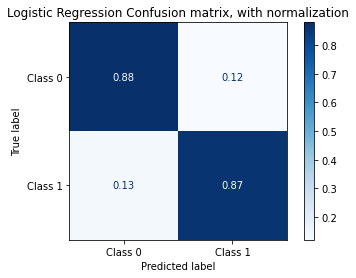

In [ ]:
# LOGREG TRAINING/TESTING/EXPLORATION FUNCTIONS DRIVER

# Feature Extract for LogReg
extracted_reviews = []

# Extract features from pos/neg data
for review, label in labeled_reviews:
    feat = feature_extract(review, label, positive_bigrams, negative_bigrams, positive_trigrams, negative_trigrams)
    extracted_reviews.append(feat)


# Run/Test Logistic Regression model
lr = logistic_regression(extracted_reviews)

In [ ]:
#FAKE/REAL USING LOGISTIC REGRESSION

fake_reviews = []
true_reviews = []

# Documents to classify (in this case unlabeled_sentiment...)
documents = unlabeled_sentiment

# For each review...
for doc, num in documents:
    # Process review
    feats = feature_extract(doc, label="na", positive_bigrams=positive_bigrams, negative_bigrams=negative_bigrams, positive_trigrams=positive_trigrams, negative_trigrams=negative_trigrams)
    # Classify review
    observed = lr.predict([feats])

    # Compare observed sentiment with review rating
    if not check_if_real_logreg(observed, num):
        fake_reviews.append((observed[0], num))
    else:
        true_reviews.append(num)

# Print list of identified fake reviews
print(fake_reviews)

[(1, 823), (0, 375), (1, 572), (0, 566), (0, 604), (0, 188), (1, 809), (1, 89), (0, 407), (0, 943), (1, 986), (0, 820), (1, 830), (0, 561), (0, 439), (0, 202), (1, 398), (0, 819), (0, 399), (1, 978), (0, 951), (0, 968), (1, 405), (1, 777), (0, 62), (1, 607), (0, 565), (0, 825), (0, 213), (1, 158), (0, 165), (1, 73), (0, 199), (1, 749), (0, 172), (1, 760), (1, 538), (1, 402), (0, 562), (0, 470), (1, 699), (1, 115), (1, 316), (0, 896), (0, 953), (1, 403), (1, 65), (0, 364), (1, 302), (1, 358), (0, 666), (1, 920), (1, 198), (1, 263), (1, 329), (0, 881), (0, 927), (0, 714), (0, 842), (0, 260), (0, 700), (0, 471), (0, 301), (0, 28), (0, 512), (0, 847), (0, 711), (1, 738), (1, 868), (1, 937), (0, 477), (1, 113), (0, 845), (1, 501), (0, 676), (0, 701), (0, 463), (1, 891), (0, 852), (0, 846), (1, 256), (1, 4), (0, 527), (1, 5), (1, 730), (1, 268), (1, 6), (1, 37), (1, 294), (1, 444), (0, 849), (1, 282), (1, 900), (1, 286), (1, 318), (1, 3), (1, 899), (1, 483), (1, 873), (0, 24), (0, 124), (0, 